### Import libraries

In [1]:
import numpy as np

from PIL import Image
import cv2
import io
import gc

import zlib

import json
import base64
import os

import matplotlib.pyplot as plt
from pprint import pprint

#### Adding special functions to read data from Supervise.ly Annotation format

In [2]:
# Supervisely Format, Bitmap [https://docs.supervise.ly/data-organization/import-export/supervisely-format#bitmap]

def base64_2_mask(s):
    z = zlib.decompress(base64.b64decode(s))
    n = np.fromstring(z, np.uint8)
    mask = cv2.imdecode(n, cv2.IMREAD_UNCHANGED)[:, :, 3].astype(bool)
    return mask

def mask_2_base64(mask):
    img_pil = Image.fromarray(np.array(mask, dtype=np.uint8))
    img_pil.putpalette([0,0,0,255,255,255])
    bytes_io = io.BytesIO()
    img_pil.save(bytes_io, format='PNG', transparency=0, optimize=0)
    bytes = bytes_io.getvalue()
    return base64.b64encode(zlib.compress(bytes)).decode('utf-8')

##### tests

In [3]:
data = "eJzrDPBz5+WS4mJgYOD19HAJAtLyQBzByAwkzW33rQNSbAE+Ia5A+v///0tvzr8LZDGWBPkFMzg8u5EG5Ez0dHEMqZiTe/Y072EFHrYH9qcalZUvCFo5qIqtlrqic0xDslGZvSVb+JRyl2q90w/WB5x9J3aqpOk+YfPVmXtFbYn/6fmq/AKydxwdO2xMJyzIuzCVxzg5/0WordG7aO3pjx0tpOoOiBgtNrZc8cXd/ViJU/rjVQl93NcO/mpL9rjBtfuDaMGj26s/WRoa33qou6eFfcpvxrzQveGWl7yTgI5j8HT1c1nnlNAEAIaTVk4="

In [4]:
msk = base64_2_mask(data)

/Users/aholdobin/anaconda3/envs/semsegm/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """


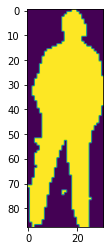

In [5]:
plt.imshow(msk)

### Implementation of dataset creation function

Setting up variables for dataset structure and location, functions to get the list of images and their masks

In [6]:
DATASET_HOME = '/Users/aholdobin/projects/data/Supervisely Person Dataset/'
DS_FMTS = ('{dsf}/img/', '{dsf}/ann/')

In [7]:
def get_ds_folders(dataset_home):
    return [folder for folder in os.listdir(dataset_home) if folder[:2]=='ds']
ds_folders = get_ds_folders(DATASET_HOME)

In [8]:
def get_files(dataset_home):
    folders = get_ds_folders(dataset_home)
    files_fmt = []
    for folder in folders:
        if folder[:2]=='ds':
            path = DS_FMTS[0].format(dsf=folder)
            files_fmt += list(map(lambda x: dataset_home+folder + '/{}/'+x, os.listdir(dataset_home+path)))
    return files_fmt

In [37]:
def get_paths_from_format(file_fmp):
    return (file_fmp.format('img'), file_fmp.format('ann') + '.json')

In [9]:
files = get_files(DATASET_HOME)

In [10]:
files[:5], len(files)

(['/Users/aholdobin/projects/data/Supervisely Person Dataset/ds6/{}/pexels-photo-547593.jpeg',
  '/Users/aholdobin/projects/data/Supervisely Person Dataset/ds6/{}/pexels-photo-395245.jpeg',
  '/Users/aholdobin/projects/data/Supervisely Person Dataset/ds6/{}/pexels-photo-106258.jpeg',
  '/Users/aholdobin/projects/data/Supervisely Person Dataset/ds6/{}/pexels-photo-279645.jpeg',
  '/Users/aholdobin/projects/data/Supervisely Person Dataset/ds6/{}/pexels-photo-795997.jpeg'],
 5711)

In [11]:
class SuperviselySegmentationClass:        
    
    def __init__(self, color, geometry_config, shape, title, ID):
        self.color = color
        self.geometry_config = geometry_config
        self.shape = shape
        self.title = title
        self.ID = ID 
        
    def __str__(self):
        return f'Supervisely Class <{self.title}> with color {self.color}, shape {self.shape} [{self.ID}]'
        
class SuperviselyTag:
    
    def __init__(self, color, name, value_type, ID):
        self.color = color
        self.name = name
        self.value_type = value_type
        self.ID = ID 
    
    def __str__(self):
        return f'Supervisely Tag <{self.name}> with color {self.color} and value_type {self.value_type} [{self.ID}]'


In [12]:
def read_process_meta(path):
    filepath = os.path.join(os.path.dirname(path), 'meta.json')
    with open(filepath) as f:
        ds_meta = json.load(f)
        
    classes = [SuperviselySegmentationClass(ID=i, **cls) for i, cls in enumerate(ds_meta['classes'])]
    tags = [SuperviselyTag(ID=i, **tag) for i, tag in enumerate(ds_meta['tags'])]
        
    return (ds_meta, classes, tags)

ds_meta, classes, tags = read_process_meta(DATASET_HOME)
    

In [13]:
pprint(ds_meta)
print('\n'.join(map(str, classes)))
print('\n'.join(map(str, tags)))

{'classes': [{'color': '#18FF00',
              'geometry_config': {},
              'shape': 'polygon',
              'title': 'person_poly'},
             {'color': '#FF0099',
              'geometry_config': {},
              'shape': 'bitmap',
              'title': 'person_bmp'},
             {'color': '#D2210A',
              'geometry_config': {},
              'shape': 'polygon',
              'title': 'neutral'}],
 'tags': [{'color': '#DF1189',
           'name': 'not-marked-people',
           'value_type': 'none'},
          {'color': '#131EEC',
           'name': 'multipart-person',
           'value_type': 'none'}]}
Supervisely Class <person_poly> with color #18FF00, shape polygon [0]
Supervisely Class <person_bmp> with color #FF0099, shape bitmap [1]
Supervisely Class <neutral> with color #D2210A, shape polygon [2]
Supervisely Tag <not-marked-people> with color #DF1189 and value_type none [0]
Supervisely Tag <multipart-person> with color #131EEC and value_type none [1]


### Investigating json masks structure

In [14]:
mask1 = '/Users/aholdobin/projects/data/Supervisely Person Dataset/ds1/ann/pexels-photo-214573.png.json'

with open(mask1) as f:
    maskjs = json.load(f)

In [15]:
maskjs.keys()

dict_keys(['description', 'tags', 'size', 'objects'])

In [16]:
maskjs['objects']

[{'description': '',
  'geometryType': 'bitmap',
  'labelerLogin': 'supervisely',
  'tags': [],
  'classTitle': 'person_bmp',
  'bitmap': {'data': 'eJwBCQb2+YlQTkcNChoKAAAADUlIRFIAAAEFAAABggEDAAAA0+1EsgAAAAZQTFRFAAAA////pdmf3QAAAAF0Uk5TAEDm2GYAAAWxSURBVHic3dtRjvQmDADgRHnIY47ARapyNJB6MaQepEi9AFUfmocodJKAscHEO6t0d1VeOjv7TbCNh51/QocBxhjtIAyzSUKJF5mjF8QYV2mauEtCR0ksYqhTdIIYxWQGEyShxHQXUUziykxiyT7QAGJBhhgkITeR6a+d+tMf/9H9uscrAt1toinGMwIVe9PM8frVS3SmWV7CHpOkazGBvn7lLtEpmr6ucUA+1l+SOCZjYzXnL0C005yzny+dzwfhePLXKsrXOFpjijmQCfeBqcV2po/mimmEo4OyXVAfjFmsoE9Rkp6y2EGcWW28uGLyhyhNPReRH4azMiCWLLZcmFqokkvkRX5hdBDRegrbiDLfJaBkBgLVVPharBDGUQosILxREh4CPYqF48hP27kSthGQSpqlFaoSTXs4LYm/oyQiETMSRhRKFHMr1rPzQIyiYAIJ5+uGm0Bq0QZyCah6aS0YvhK9WdwbQneEF0V547b1SLvAzeJWgq/6ceUsJl7EUhB+bUcklq5wfeGvuW+Eu0QumWqF/agIXyLyrqyP50wtxkpsrMjLbz4kgiYi9UTe2Y+nHBErFePHhDWNMCDOBhpYEVEDMWK5E4GK5QyJCJ8X46NCtcLlxegKS4XuCENElQssBhYagb0UEpY2kkbbc4pELEhs5dI3Yi4BXbsHeXtvA/qUkR7vtZhbQTaRvHHtJY5K2CS2co2NinWO+BrMLPGfRkRuu6Pit78k8QcHcKSdIYtV

### Counting number of person objects annotated with both types

In [15]:
num_poly, num_bmp = 0, 0
for fm in files:
    with open(fm.format('ann')+'.json') as f:
        annotation_json = json.load(f)
        for obj in annotation_json['objects']:
            if obj['classTitle'] =='person_poly':
                num_poly += 1
                # quit = True
                # break
            if obj['classTitle'] =='person_bmp':
                num_bmp += 1
gc.collect()
    # if quit: break
num_poly, num_bmp

(5073, 1586)

### Implementing functions to generate mask from json

In [18]:
def paste_bitmap(zero_mask, obj, verbose_visualize=False):
    if 'bitmap' not in obj:
        raise ValueError('Wrong segmentation type')
    segm = base64_2_mask(obj['bitmap']['data'])
    [h, w] = obj['bitmap']['origin']
    if verbose_visualize:
        print(f'Segmenfation shape {segm.shape}')
        print(f'Max segmentationn value {segm.astype("float32").max()}')

        print(f'Shape of `zero_mask`: {zero_mask.shape}')
        plt.figure()
        plt.imshow(segm)
        plt.figure()
        plt.imshow(img)
        print([h, w])
    zero_mask[w:w + segm.shape[0], h:h + segm.shape[1]][segm] = segm[segm]
    
    if verbose_visualize:
        plt.figure()
        plt.imshow(zero_mask)
    

In [19]:
img = np.array(Image.open('/Users/aholdobin/projects/data/Supervisely Person Dataset/ds1/img/pexels-photo-214573.png'))

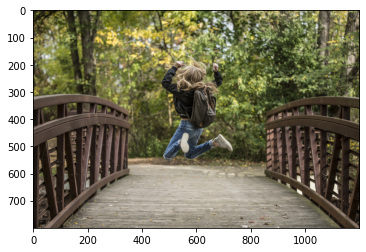

In [20]:
plt.imshow(img)

/Users/aholdobin/anaconda3/envs/semsegm/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """


Segmenfation shape (386, 261)
Max segmentationn value 1.0
Shape of `zero_mask`: (800, 1200)
[472, 166]


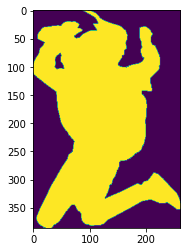

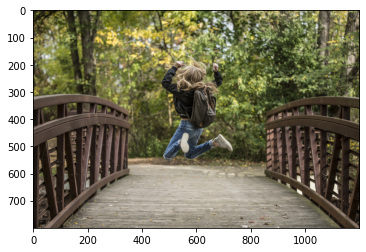

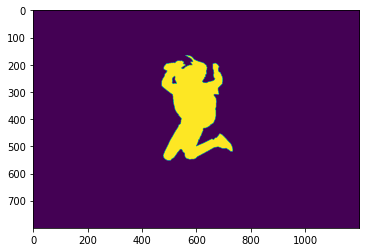

In [21]:
paste_bitmap(np.zeros(img.shape[:2]), maskjs['objects'][0], verbose_visualize=True)

In [114]:
def draw_polygon(zero_mask, obj):
    if 'points' not in obj:
        raise ValueError('Wrong segmentation type')
    points = obj['points']['exterior']
    num_of_points = len(points)# (obj['points']['exterior'])
    for i in range(num_of_points):
        cv2.line(zero_mask, tuple(points[i]), tuple(points[(i+1) % num_of_points]), 0, 5)
    # probably not working TODO fix
    # for inter in obj['points']['interior']:
    #    cv2.line(zero_mask, tuple(inter[i]), tuple(inter[(i+1) % num_of_points]), 0, 3)
    plt.figure(figsize=(10,15))
    plt.imshow(zero_mask)

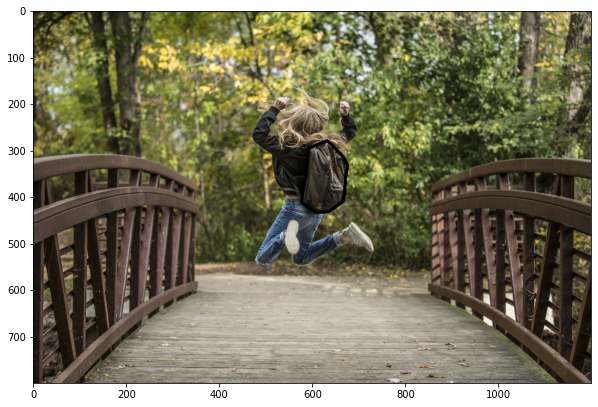

In [23]:
draw_polygon(img.copy(), maskjs['objects'][1])

In [118]:
def paste_polygon(zero_mask, obj, verbose_visualize=False):
    if 'points' not in obj:
        raise ValueError('Wrong segmentation type')
    cv2.fillPoly(zero_mask, [np.array(obj['points']['exterior'])], 1)
    for inter in obj['points']['interior']:
        cv2.fillPoly(zero_mask, [np.array(inter)], 0)
    if verbose_visualize:
        plt.figure(figsize=(10,15))
        plt.imshow(zero_mask)

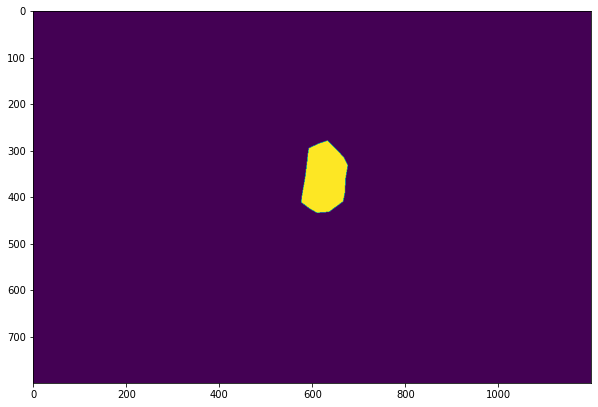

In [119]:
paste_polygon(np.zeros(img.shape[:2]), maskjs['objects'][1], verbose_visualize=True)

In [120]:
PASTE = {
    'bitmap' : paste_bitmap,
    'polygon' : paste_polygon
}

def get_masks_from_json_annotation(mask_json_path):
    with open(mask_json_path) as f:
        mask_data = json.load(f)
    
    height = mask_data['size']['height']
    width = mask_data['size']['width']
    mask = np.zeros([height, width], dtype='float32')
    for obj in mask_data['objects']:
        if obj['classTitle'] in ['person_bmp', 'person_poly']:
            PASTE[obj['geometryType']](mask, obj)
    return mask
    

In [121]:
paths2 = get_paths_from_format(files[10])
image2 = Image.open(paths2[0])
mask2 = get_masks_from_json_annotation(paths2[1])

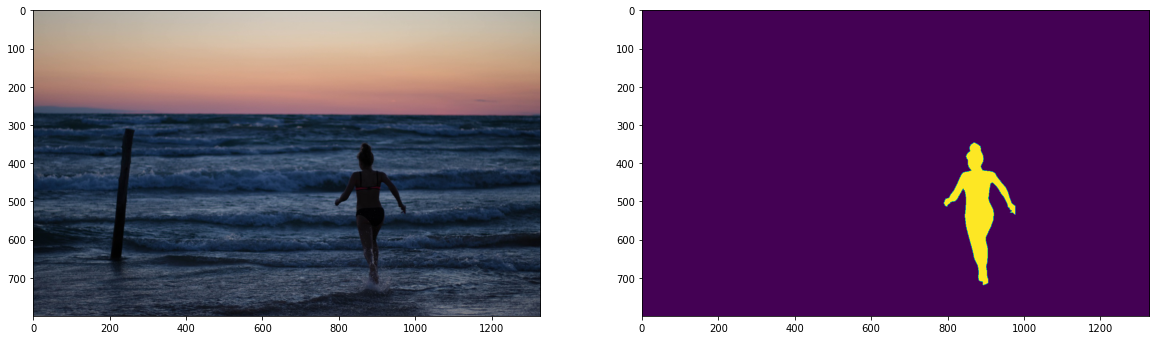

In [122]:
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(image2)
plt.subplot(122)
plt.imshow(mask2)

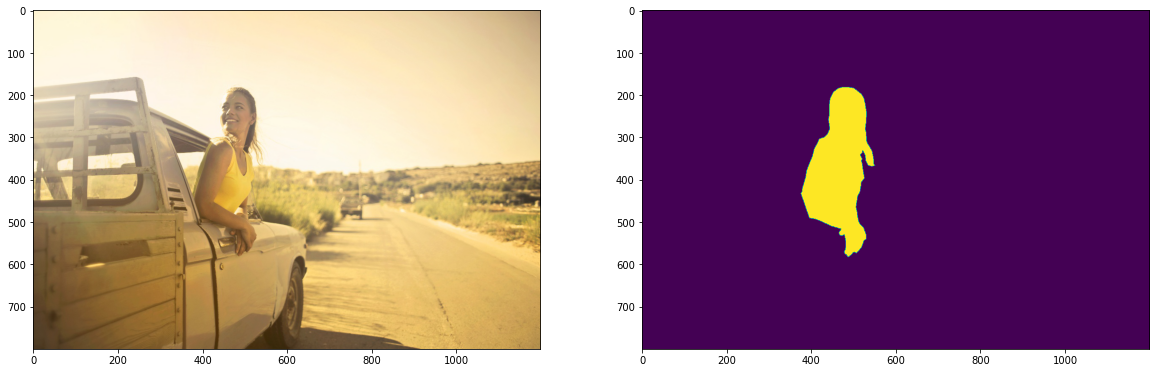

In [123]:
def draw_image_segmentation(num):
    paths = get_paths_from_format(files[num])
    image = Image.open(paths[0])
    mask = get_masks_from_json_annotation(paths[1])

    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    plt.imshow(image)
    plt.subplot(122)
    plt.imshow(mask)

draw_image_segmentation(55)

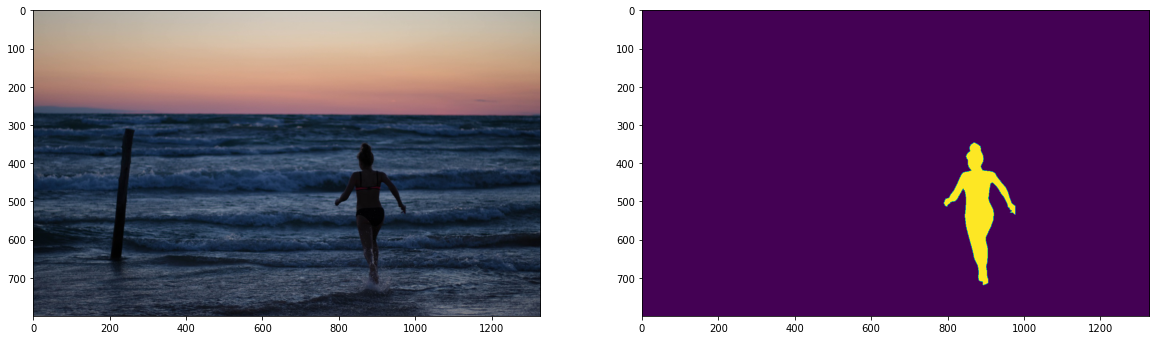

In [124]:
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(image2)
plt.subplot(122)
plt.imshow(mask2)

/Users/aholdobin/anaconda3/envs/semsegm/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """


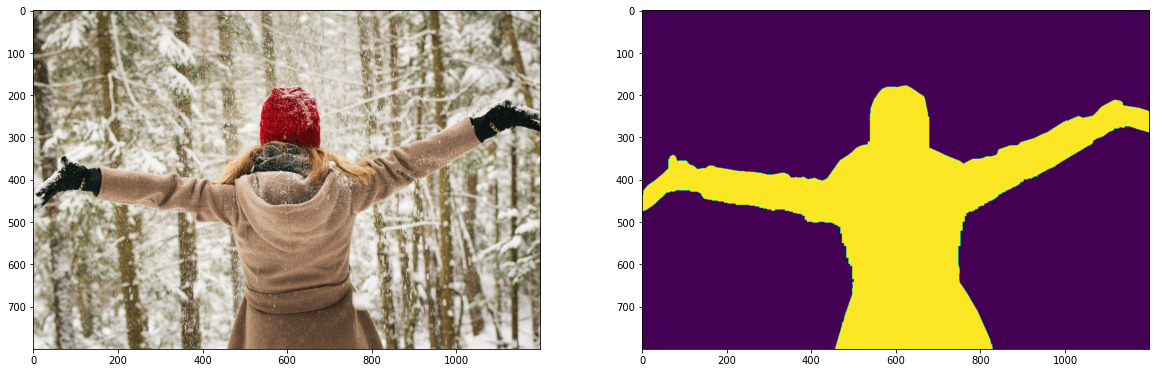

In [125]:
draw_image_segmentation(5000)

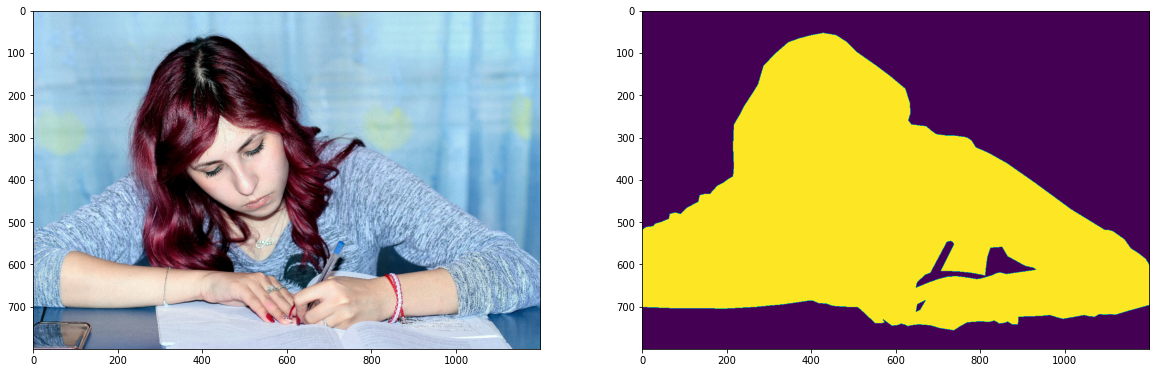

In [126]:
draw_image_segmentation(16)

### Adding meta (masks loactions and size on the image)

In [398]:
def paste_bitmap_meta(zero_mask, obj):
    if 'bitmap' not in obj:
        raise ValueError('Wrong segmentation type')
    segm = base64_2_mask(obj['bitmap']['data'])
    [x, y] = obj['bitmap']['origin']
    zero_mask[y:y + segm.shape[0], x:x + segm.shape[1]][segm] = segm[segm]
    meta = {
        'shape': segm.shape,
        'coords': [x, y],
        'type': 'bitmap',
#         'tags': obj['tags']
    }
    return meta

In [400]:
def paste_polygon_meta(zero_mask, obj):
    if 'points' not in obj:
        raise ValueError('Wrong segmentation type')
    exterior = np.array(obj['points']['exterior'])
    cv2.fillPoly(zero_mask, [exterior], 1)
    for inter in obj['points']['interior']:
        cv2.fillPoly(zero_mask, [np.array(inter)], 0)
    left_top = exterior.min(axis=0)
    right_bottom = exterior.max(axis=0)
    shape = right_bottom - left_top; shape = shape[1], shape[0]
    meta = {
        'shape': shape,
        'coords': left_top,
        'type': 'polygon',
#         'tags': obj['tags']
    }
    return meta

In [401]:
PASTE_WITH_META = {
    'bitmap' : paste_bitmap_meta,
    'polygon' : paste_polygon_meta
}

def get_masks_meta_from_json_annotation(mask_json_path):
    with open(mask_json_path) as f:
        mask_data = json.load(f)
    
    meta_people = []
    
    height = mask_data['size']['height']
    width = mask_data['size']['width']
    mask = np.zeros([height, width], dtype='float32')
    for obj in mask_data['objects']:
        if obj['classTitle'] in ['person_bmp', 'person_poly']:
            meta_people.append(PASTE_WITH_META[obj['geometryType']](mask, obj))
    return mask, meta_people
    

[{'shape': (400, 174), 'coords': array([375, 182]), 'type': 'polygon'}]


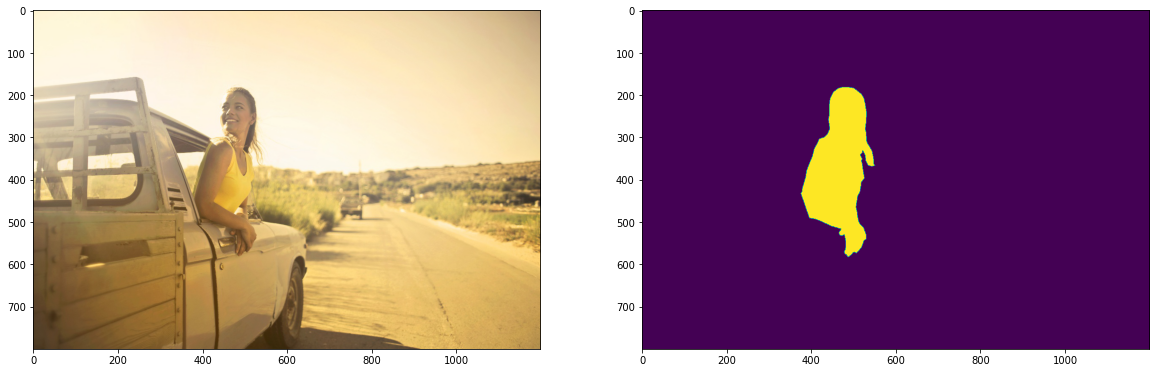

In [402]:
def draw_image_segmentation_meta(num):
    paths = get_paths_from_format(files[num])
    image = Image.open(paths[0])
    mask, meta = get_masks_meta_from_json_annotation(paths[1])

    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    plt.imshow(image)
    plt.subplot(122)
    plt.imshow(mask)
    print(meta)

draw_image_segmentation_meta(55)

####  Examples

In [403]:
i = -1

0
[{'shape': (747, 722), 'coords': array([42, 52]), 'type': 'polygon'}]


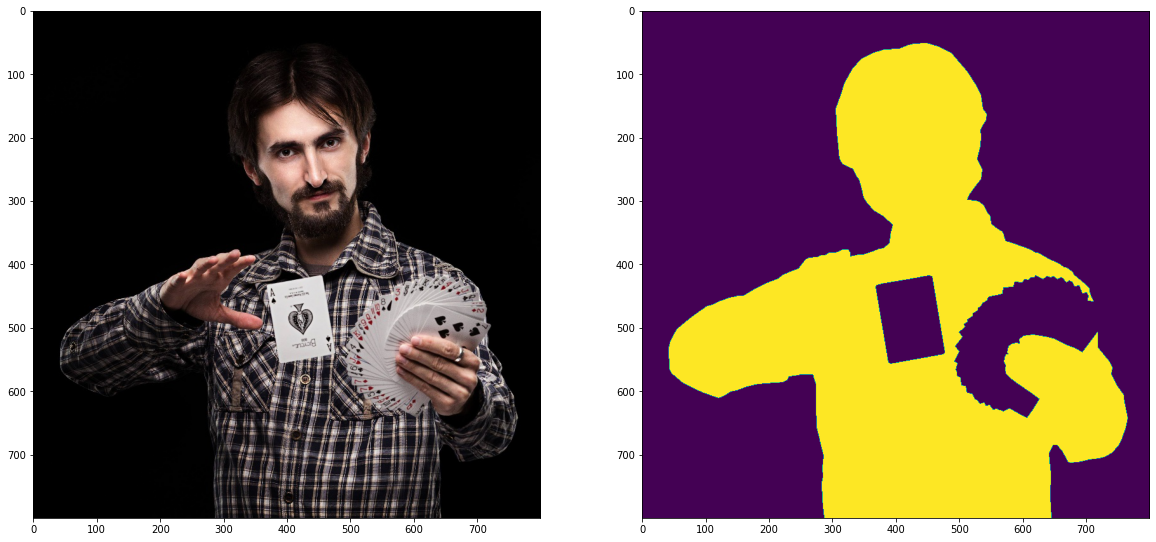

In [404]:
i +=1
print(i)
draw_image_segmentation_meta(i)

2
[{'shape': (96, 139), 'coords': array([  1, 423]), 'type': 'polygon'}, {'shape': (169, 193), 'coords': array([382, 319]), 'type': 'polygon'}, {'shape': (280, 217), 'coords': array([618, 197]), 'type': 'polygon'}, {'shape': (300, 160), 'coords': array([987, 284]), 'type': 'polygon'}]


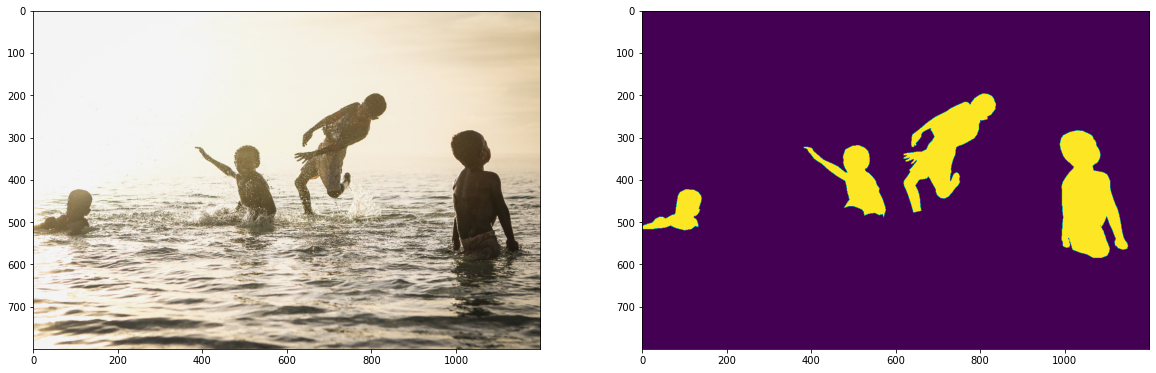

In [406]:
i +=1
print(i)
draw_image_segmentation_meta(i)

3
[{'shape': (799, 918), 'coords': array([281,   0]), 'type': 'polygon'}]


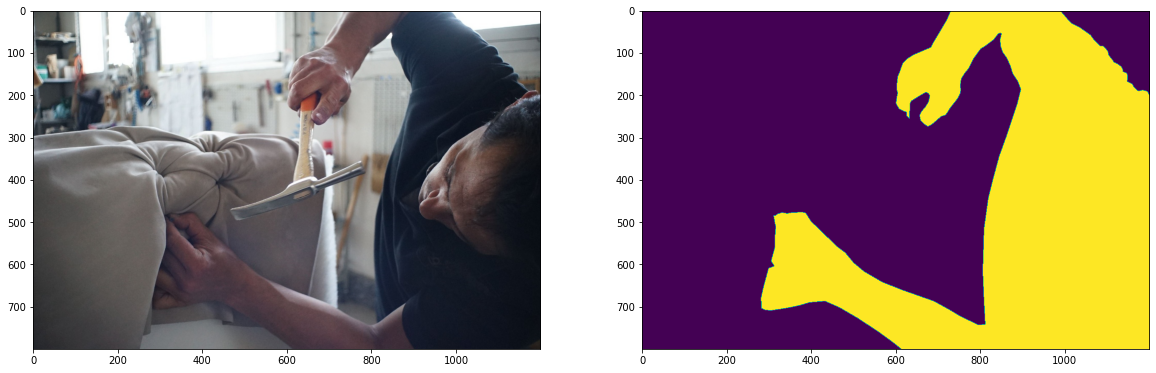

In [407]:
i +=1
print(i)
draw_image_segmentation_meta(i)

117
[{'shape': (484, 164), 'coords': array([703, 109]), 'type': 'polygon'}]


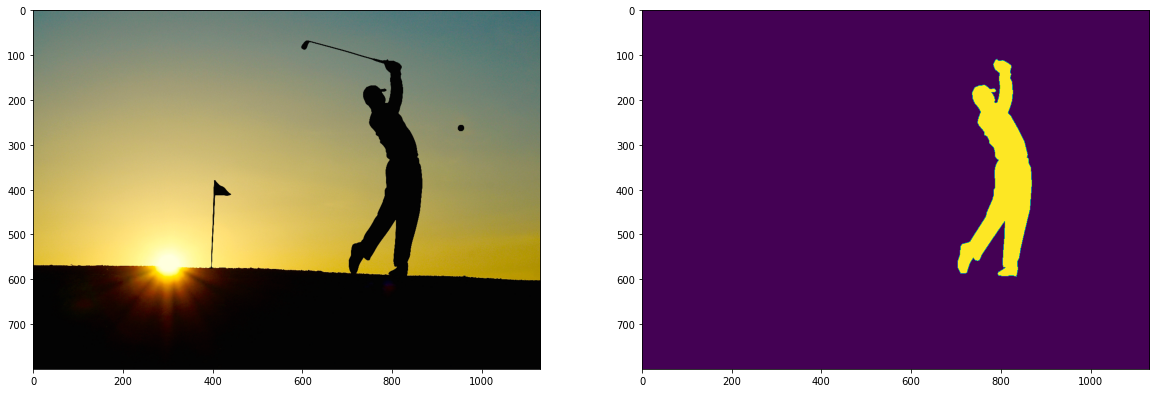

In [408]:
i +=1
print(i)
draw_image_segmentation_meta(i)

In [409]:
i=15

16
[{'shape': (701, 1199), 'coords': array([ 0, 54]), 'type': 'polygon'}]


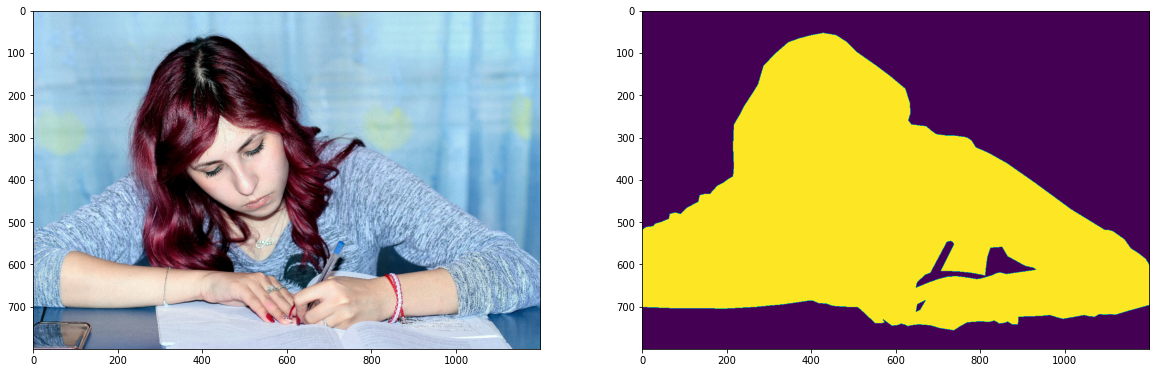

In [410]:
i += 1
print(i)
draw_image_segmentation_meta(i)

#### Investigation of objects in the data + check function works with all images

In [132]:
from tqdm import tqdm

In [411]:
metas = []
for file_fmt in tqdm(files):
    mask_path = get_paths_from_format(file_fmt)[1]
    _, meta = get_masks_meta_from_json_annotation(mask_path)
    metas.append(meta)
    gc.collect()

 35%|███▍      | 1988/5711 [05:01<09:18,  6.67it/s]/Users/aholdobin/anaconda3/envs/semsegm/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """
100%|██████████| 5711/5711 [14:56<00:00,  6.37it/s]


In [290]:
all_tags = [m['tags'] for img in metas for m in img  if len(m['tags'])>0 ]

In [292]:
all_tags

[]

In [412]:
metas[0]

[{'shape': (747, 722), 'coords': array([42, 52]), 'type': 'polygon'}]

In [413]:
len(metas)

5711

The next block of code will count number of objects (people) on the image. And show the distribution of number of people on the image.

In [285]:
people_counts = list(map(len, metas))
cc = dict()
for c in people_counts:
    if c in cc:
        cc[c] += 1
    else:
        cc[c] = 1

In [286]:
sorted(cc.items(), key=lambda x: x[0])

[(1, 5037),
 (2, 517),
 (3, 91),
 (4, 36),
 (5, 19),
 (6, 7),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1)]

As we can see the major part of images has only 1 person on them. <b>In order to safe time only that part will be processed</b> - <i>the first version of the Supervise.ly Dataset</i>

In [288]:
1280/720, 1920/1080, 16/9

(1.7777777777777777, 1.7777777777777777, 1.7777777777777777)

In [323]:
4/3

1.3333333333333333

In [324]:
21/9

2.3333333333333335

In [ ]:
crop_function()

### Adding face detection to filter out images without faces (taken from behind or too dark, etc.)

#### test library mtcnn

In [298]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 1.1 MB/s eta 0:00:01


In [299]:
import mtcnn

In [300]:
face_det = mtcnn.MTCNN()

[{'box': [356, 144, 146, 195], 'confidence': 0.9987049102783203, 'keypoints': {'left_eye': (399, 223), 'right_eye': (467, 207), 'nose': (445, 268), 'mouth_left': (420, 296), 'mouth_right': (477, 282)}}]


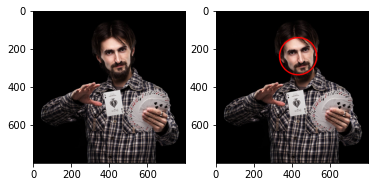

In [309]:
paths1 = get_paths_from_format(files[0])
image1 = np.array(Image.open(paths1[0]))
plt.subplot(121)
plt.imshow(image1)
det = face_det.detect_faces(image1)
bbox1 = det[0]['box']

cv2.circle(image1, (bbox1[0]+bbox1[2]//2, bbox1[1]+bbox1[3]//2), max(bbox1[2], bbox1[3])//2, (255, 0, 0), 5)
plt.subplot(122)
plt.imshow(image1)
print(det)

### Implementing function for an example preparation

In [414]:
paths16 = get_paths_from_format(files[16])
with open(paths16[1]) as f:
    mask_data16 = json.load(f)
image16 = np.array(Image.open(paths16[0]))

height = mask_data16['size']['height']
width = mask_data16['size']['width']
mask16 = np.zeros([height, width], dtype='float32')
meta = None
for obj in mask_data16['objects']:
    if obj['classTitle'] in ['person_bmp', 'person_poly']:
        # if meta:
            # return None
        meta = PASTE_WITH_META[obj['geometryType']](mask16, obj)

coords = meta['coords']
shape = meta['shape']

In [415]:
meta

{'shape': (701, 1199), 'coords': array([ 0, 54]), 'type': 'polygon'}

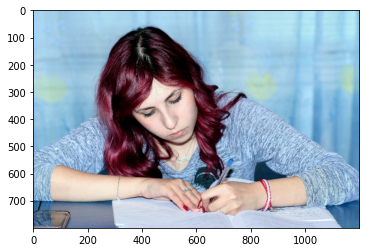

In [416]:
plt.imshow(image16)

In [417]:
print(coords)
print(shape)

print(image16.shape)

[ 0 54]
(701, 1199)
(800, 1200, 3)


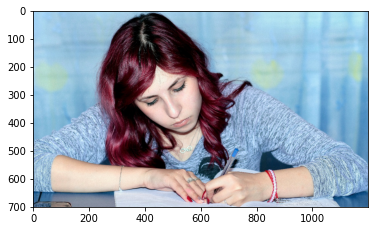

In [418]:
plt.imshow(image16[coords[1]:coords[1]+shape[0], coords[0]:coords[0]+shape[1]])

##### Implementing function that will retrieve suitable example from image 

In [667]:
EPS = 1/32
ASPECT_RATIO = 16/9
def cropped_example(image, mask, meta):
    
    def available_borders(image, meta):
        im_shape = image.shape[:2]
        segm_bbox = meta['coords'], meta['shape']
        top_left = segm_bbox[0][1], segm_bbox[0][0]
        bottom_right = im_shape - np.array([segm_bbox[0][1] + segm_bbox[1][0], segm_bbox[0][0]+segm_bbox[1][1]])
        #print(f'*available_borders* Im shape {image.shape}, top_left {top_left}, bottom_right {bottom_right}')
        return np.concatenate([top_left, bottom_right])
        
    def augment_segmentation(image, mask, meta):
        coords = meta['coords']
        shape = meta['shape']
        segmentation_image = image[coords[1]:coords[1]+shape[0], coords[0]:coords[0]+shape[1]]
        segmentation_mask = mask[coords[1]:coords[1]+shape[0], coords[0]:coords[0]+shape[1]]
        #print(f'*augment_segmentation* segmentation shape {segmentation_image.shape}')
        
        if segmentation_image.shape[0]/ASPECT_RATIO + EPS < segmentation_image.shape[1]:
            
            needed_height = int(np.ceil(segmentation_mask.shape[1] * ASPECT_RATIO))
            ex_image = np.zeros([needed_height, segmentation_image.shape[1], 3])
            ex_mask = np.zeros([needed_height, segmentation_image.shape[1]])
            #print(f'*augment_segmentation* ex_image shape {ex_image.shape}')
            
            if needed_height > image.shape[0]:
                ex_image[needed_height - image.shape[0]:, :] = image[:, coords[0]:coords[0]+shape[1]]
                ex_mask[needed_height - image.shape[0]:, :] = mask[:, coords[0]:coords[0]+shape[1]]
            else:
                ab = available_borders(image, meta)
                if ab[0] > needed_height - segmentation_image.shape[0]:
                    bot = 0
                    top = needed_height - segmentation_image.shape[0]
                else:
                    top = ab[0]
                    bot = needed_height - ab[0] - segmentation_image.shape[0]
                ex_image[:, :] = image[coords[1]-top:coords[1]+shape[0]+bot, coords[0]:coords[0]+shape[1]] 
                ex_mask[:, :] = mask[coords[1]-top:coords[1]+shape[0]+bot, coords[0]:coords[0]+shape[1]] 
            
            return ex_image, ex_mask
        else:
            needed_width = int(np.ceil(segmentation_mask.shape[0] / ASPECT_RATIO))
            ex_image = np.zeros([segmentation_image.shape[0], needed_width, 3])
            ex_mask = np.zeros([segmentation_image.shape[0], needed_width])
            #print(f'*augment_segmentation* ex_image shape {ex_image.shape}')
            
            if needed_width > image.shape[1]:
                ex_image[:, (needed_width - image.shape[1])//2:(needed_width - image.shape[1])//2+image.shape[1]] = image[coords[1]:coords[1]+shape[0],:]
                ex_mask[:, (needed_width - image.shape[1])//2:(needed_width - image.shape[1])//2+image.shape[1]] = mask[coords[1]:coords[1]+shape[0],:]
            else:
                ab = available_borders(image, meta)
                if ab[1] > needed_width - segmentation_image.shape[1]:
                    rgt = 0
                    lft = needed_width - segmentation_image.shape[1]
                else:
                    lft = ab[1]
                    rgt = needed_width - ab[1] - segmentation_image.shape[1]
                #print(f'rgh {rgt}, lft {lft}')
                #print(image.shape, -coords[0]+lft+coords[0]+shape[1]+rgt, coords[0]-lft, coords[0]+shape[1]+rgt)
                ex_image[:, :] = image[coords[1]:coords[1]+shape[0], coords[0]-lft:coords[0]+shape[1]+rgt] 
                ex_mask[:, :] = mask[coords[1]:coords[1]+shape[0], coords[0]-lft:coords[0]+shape[1]+rgt] 
            
            return ex_image, ex_mask
    #print(meta)
    coords = meta['coords']
    shape = meta['shape']
    height, width = shape[0], shape[1]
    # filtre by size
    if min(width, height) < 128:
        return None
    if abs(height/width - ASPECT_RATIO) < EPS:
        return (
            image[coords[1]:coords[1]+shape[0], coords[0]:coords[0]+shape[1]],
            mask[coords[1]:coords[1]+shape[0], coords[0]:coords[0]+shape[1]]
        )
    else:
        return augment_segmentation(image, mask, meta)

In [668]:
PASTE_WITH_META = {
    'bitmap' : paste_bitmap_meta,
    'polygon' : paste_polygon_meta
}

def prepare_example(file_fmt):
    # Get pathes to an image and its mask with metadata and load them
    paths = get_paths_from_format(file_fmt)
    with open(paths[1]) as f:
        mask_data = json.load(f)
    image = np.array(Image.open(paths[0]))
    #print(f'*prepare_example* image.shape {image.shape}')
    
    # Create mask from metadata
    height = mask_data['size']['height']
    width = mask_data['size']['width']
    mask = np.zeros([height, width], dtype='float32')
    meta = None
    
    for obj in mask_data['objects']:
        if obj['classTitle'] in ['person_bmp', 'person_poly']:
            # If the second person appears, break, as we use only images with singe person 
            if meta:
                return None
            meta = PASTE_WITH_META[obj['geometryType']](mask, obj)
            
    coords = meta['coords']
    shape = meta['shape']
    
    # Check if we can find the face
    det = face_det.detect_faces(image[coords[1]:coords[1]+shape[1], coords[0]:coords[0]+shape[0]])
    if len(det) > 0:
        return cropped_example(image, mask, meta)
    return None

In [619]:
i=0 #114, 16

33
{'shape': (726, 764), 'coords': array([339,  73]), 'type': 'polygon'}
*augment_segmentation* segmentation shape (726, 764, 3)
*augment_segmentation* ex_image shape (1359, 764, 3)


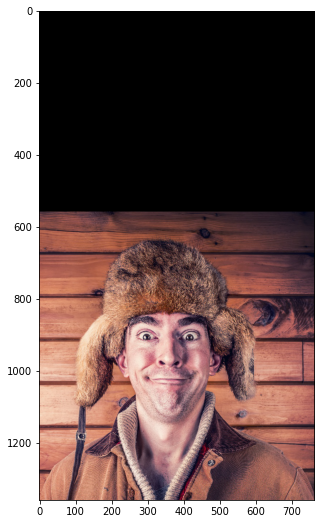

In [652]:
i+=1
print(i)
img, msk = prepare_example(files[i])
plt.figure(figsize=(16,9))
plt.imshow(img/255)

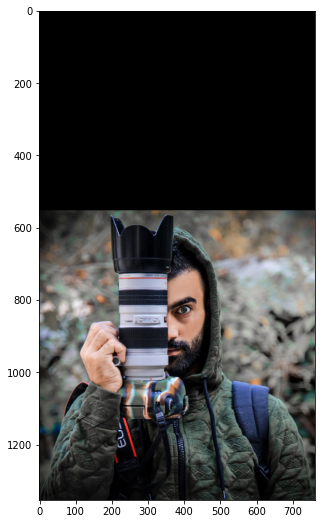

In [500]:
plt.figure(figsize=(16,9))
plt.imshow(img/255)

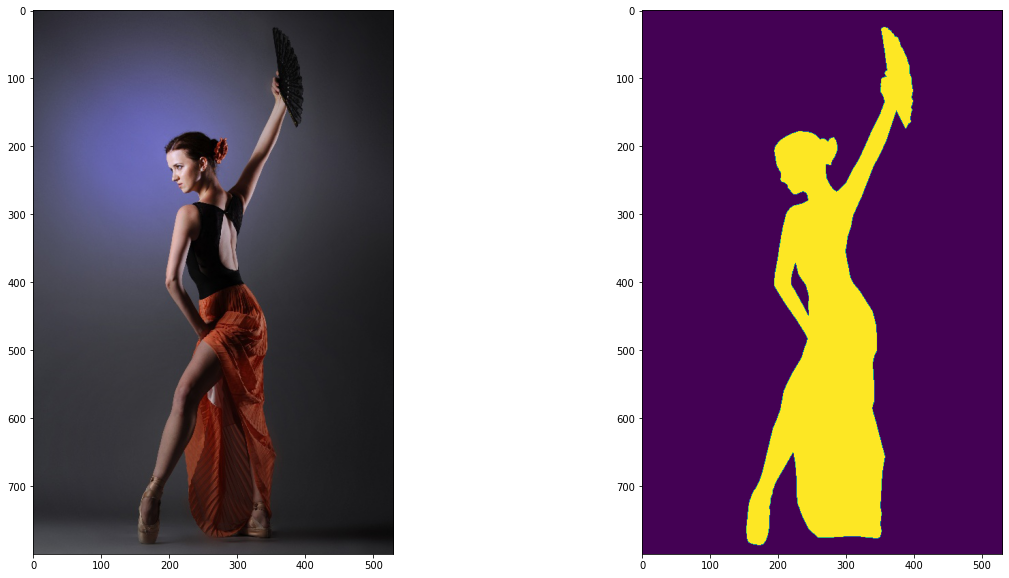

In [616]:
draw_image_segmentation(114)

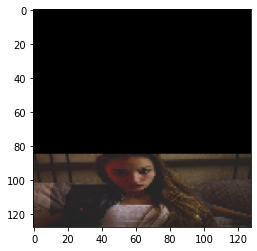

In [496]:
plt.imshow(cv2.resize(img/255, dsize=(128,128)))

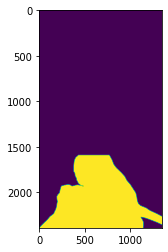

In [497]:
plt.imshow(msk)

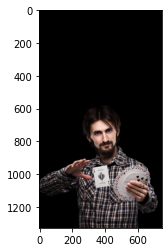

In [386]:
plt.imshow(img/255)

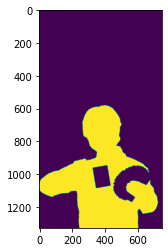

In [385]:
plt.imshow(msk)

### Originals (in terms of the scale) Dataset creation

In [657]:
cnt=0
for file in tqdm(files):
    res = prepare_example(file)
    if res:
        cnt+=1
        gc.collect()
#         store(path, res)

 35%|███▍      | 1987/5711 [20:08<44:27,  1.40it/s]  /Users/aholdobin/anaconda3/envs/semsegm/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """
 47%|████▋     | 2669/5711 [26:52<30:38,  1.65it/s]


ValueError: could not broadcast input array from shape (764,377,3) into shape (764,350,3)

In [ ]:
cnt=0
for file in tqdm(files[2669:]):
    res = prepare_example(file)
    if res:
        cnt+=1
        gc.collect()
#         store(path, res)

  0%|          | 8/3042 [00:05<34:09,  1.48it/s]/Users/aholdobin/anaconda3/envs/semsegm/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """
 19%|█▉        | 584/3042 [07:29<32:41,  1.25it/s]

In [669]:
prepare_example(files[2669])

(array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0.,